In [1]:
import os
import ast
import collections

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import jaccard_score
from scipy.spatial import distance
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score, 
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    auc, 
    balanced_accuracy_score
)


import torch
from torch_geometric import seed_everything
from torch_geometric.data import HeteroData, Data
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.utils import to_networkx, homophily, subgraph, remove_isolated_nodes
import torch_geometric.transforms as T
import torch.nn.functional as F




In [3]:
# Config

DATA_DIR = '/mnt/graphdata/lpa/'
FEATURES_DIR = '/mnt/graphdata/features/community'
RANDOM_SEED = 42

IS_MULTI_LABEL = True
FEATURES_HIERARCHICAL_LEVEL = 2  # 0-4
METADATA_TYPE = 'tissue' # 'tissue' or 'taxon'
EDGE_WEIGHT_THRESHOLD = 0

ACTIVATION_THRESHOLD = 0.5
EVAL_MASK_RATIO = 0.99
MASK_TYPE = 'random' # 'random', 'random_ones', 'high_homophily', 'low_homophily'
FP_ITERATIONS = 100
EXCLUDE_ISOLATED_NODES = True
MASK_VALUE = float('nan') # 0, float('nan') 

seed_everything(42)

In [18]:
class IdentityEncoder(object):
    # The 'IdentityEncoder' takes the raw column values and converts them to
    # PyTorch tensors.
    def __init__(self, dtype=None, is_list=False, is_tensor=False):
        self.dtype = dtype
        self.is_list = is_list
        self.is_tensor = is_tensor

    def __call__(self, df):
        if self.is_tensor:
            if self.is_list:
                return torch.stack([torch.tensor([el]) for el in df.values])
            return torch.from_numpy(df.values).to(self.dtype)
        else:
            return df

class ListEncoder(object):
    def __init__(self, sep=',', is_tensor=False):
        self.sep = sep
        self.is_tensor = is_tensor

    def __call__(self, df):
        eval_df = df.apply(
            lambda x: [val for val in ast.literal_eval(x)])
        return torch.stack([torch.tensor(el) for el in eval_df.values])


def get_label_from_communities(communities, level=FEATURES_HIERARCHICAL_LEVEL):
    if 'intermediateCommunityIds' not in communities.columns:
        communities['targetLevel'] = communities['communityId']
    else:    
        communities['targetLevel'] = communities['intermediateCommunityIds'].apply(lambda x: ast.literal_eval(x)[level])
    return communities


def load_node_tensor(df, index_col, encoders=None):
    mapping = {index: i for i, index in enumerate(df[index_col].unique())}
    x = torch.ones(size=(len(df.index), 1))

    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)
        x = x.float()
    
    assert len(mapping) == len(df.index.unique())
    return x, mapping

def load_edge_tensor(df, src_index_col, src_mapping,
                     dst_index_col, dst_mapping, encoders=None):
    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])
    edge_attr = None
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr


def get_single_class_encoding(sotu_nodes, sotu_tissues, tissue_fts):
    if METADATA_TYPE == 'tissue':
        md_key = 'btoId'
        run_col = 'numRuns'
    elif METADATA_TYPE == 'taxon':
        md_key = 'taxId'
        run_col = 'count'

    most_common = sotu_tissues.groupby('sotu')[run_col].idxmax()
    most_common = sotu_tissues.loc[most_common]

    sotu_fts = pd.merge(
        most_common,
        tissue_fts[['nodeId', 'appId', 'targetLevel']],
        left_on=md_key, 
        right_on='appId',
        how='left')
    sotu_fts = pd.merge(
        sotu_nodes,
        sotu_fts[['sotu', 'targetLevel']],
        left_on='sotu', 
        right_on='sotu',
        how='left')
    
    # fill missing values with max targetLevel + 1
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(sotu_fts['targetLevel'].max() + 1)
    # sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(-1)
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(int)

    return sotu_fts


def get_multi_class_encoding(sotu_nodes, sotu_tissues, tissue_fts, mappings, metadata_type=METADATA_TYPE):
    if metadata_type == 'tissue':
        md_key = 'btoId'
    elif metadata_type == 'taxon':
        md_key = 'taxId'
    sotu_fts = pd.merge(
        sotu_tissues,
        tissue_fts[['nodeId', 'appId', 'targetLevel']],
        left_on=md_key, 
        right_on='appId',
        how='left')
    sotu_fts = pd.merge(
        sotu_nodes,
        sotu_fts[['sotu', 'targetLevel']],
        left_on='sotu', 
        right_on='sotu',
        how='left')
    # fill missing values with max targetLevel + 1
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(sotu_fts['targetLevel'].max() + 1)
    # sotu_fts['targetLevel'] = sotu_fts['targetLevel'].fillna(-1)
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(int)
    sotu_fts = sotu_fts.groupby('sotu')['targetLevel'].apply(list).reset_index()

    # convert to one-hot encoding using MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    sotu_fts['targetLevel'] = mlb.fit_transform(sotu_fts['targetLevel']).tolist()
    sotu_fts['targetLevel'] = sotu_fts['targetLevel'].astype(str)

    mappings['sotu_x'] = mlb.classes_

    return sotu_fts


def create_pyg_graph(
        metadata_type=METADATA_TYPE,
        hierarchy_level=FEATURES_HIERARCHICAL_LEVEL,
        EDGE_WEIGHT_THRESHOLD=EDGE_WEIGHT_THRESHOLD,
):
    data = Data()
    mappings = {}

    # tissue_nodes = pd.read_csv(f'{DATA_DIR}/all_tissues.csv', index_col=False)
    # tissue_edges = pd.read_csv(f'{DATA_DIR}/tissue_edges.csv', index_col=False)

    sotu_nodes = pd.read_csv(f'{DATA_DIR}/sotu_nodes.csv', index_col=False)
    sotu_edges = pd.read_csv(f'{DATA_DIR}/sotu_sequence_alignment_edges.csv', index_col=False)

    if metadata_type == 'tissue':
        sotu_metadata =  pd.read_csv(f'{DATA_DIR}/sotu_tissues.csv', index_col=False)
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/tissue_leiden_communities.csv', index_col=False)

    elif metadata_type == 'taxon':
        sotu_metadata = pd.read_csv(f'{DATA_DIR}/sotu_has_inferred_taxon_edges.csv', index_col=False)
        sotu_metadata = sotu_metadata.rename(columns={'targetAppId': 'taxId', 'sourceNode': 'nodeId', 'sourceAppId': 'sotu'})
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/taxon_leiden_communities.csv', index_col=False)

    metadata_fts = get_label_from_communities(metadata_fts, level=hierarchy_level)

    print(f'Total number of classes: {metadata_fts["targetLevel"].nunique()}')

    if IS_MULTI_LABEL:
        sotu_fts = get_multi_class_encoding(sotu_nodes, sotu_metadata, metadata_fts, mappings)
    else:
        sotu_fts = get_single_class_encoding(sotu_nodes, sotu_metadata, metadata_fts)

    sotu_x, sotu_mapping = load_node_tensor(
        df=sotu_fts,
        index_col='sotu',
        encoders={
            'targetLevel': ListEncoder(is_tensor=True) if IS_MULTI_LABEL else IdentityEncoder(dtype=torch.long, is_tensor=True)
        }
    )
    sotu_x = sotu_x.long()
    data.x = sotu_x
    mappings['sotu'] = sotu_mapping

    print(f'SOTU nodes: {sotu_x.shape}')

    sotu_edges = sotu_edges[sotu_edges['weight'] > EDGE_WEIGHT_THRESHOLD]
    sotu_edge_index, sotu_edge_attr = load_edge_tensor(
        df=sotu_edges,
        src_index_col='sourceAppId',
        src_mapping=sotu_mapping,
        dst_index_col='targetAppId',
        dst_mapping=sotu_mapping,
        encoders={
            'weight': IdentityEncoder(dtype=torch.float, is_tensor=True)
        } 
    )
    data.edge_index = sotu_edge_index
    data.edge_attr = sotu_edge_attr
    print(f'SOTU edges: {sotu_edge_index.shape}')

    data = T.ToUndirected()(data)

    return data, mappings

In [5]:
data, mappings = create_pyg_graph()

Total number of classes: 195
SOTU nodes: torch.Size([513176, 145])
SOTU edges: torch.Size([2, 26341751])


In [12]:
# Helpers + Stats

def round_to_threshold(data, threshold=ACTIVATION_THRESHOLD):
    data.x[data.x >= threshold] = 1
    data.x[data.x < threshold] = 0
    return data

def get_total_ones(data):
    # handle nan values
    tmp = data.clone()
    tmp.x[torch.isnan(tmp.x)] = 0
    print(f'Total unique sOTU-tissue associations: {tmp.x.sum().item()}')


# get average number of classes per node
num_classes = data.x.sum(dim=-1).float()
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of classes: {data.x.shape[1]}')
print(f'Number of classes per node: {num_classes}')
print(f'Average number of classes per node: {num_classes.mean()}')


Number of nodes: 513176
Number of classes: 145
Number of classes per node: tensor([5., 2., 1.,  ..., 1., 1., 1.])
Average number of classes per node: 1.7689545154571533


In [ ]:
# Run Feature Propagation without masking
cloned_data = data.clone()
cloned_data.x = cloned_data.x.float()
# remove edges with weight < 0.5
# cloned_data.edge_attr[cloned_data.edge_attr < 0.5] = 0
cloned_data.edge_index = cloned_data.edge_index[:, cloned_data.edge_attr > 0.8]
cloned_data.edge_attr = cloned_data.edge_attr[cloned_data.edge_attr > 0.8]


missing_mask = cloned_data.x == 0
transform = T.FeaturePropagation(missing_mask=missing_mask, num_iterations=FP_ITERATIONS)
cloned_data = transform(cloned_data)
cloned_data = round_to_threshold(cloned_data, threshold=0.9)
get_total_ones(cloned_data)

print(f'Original data: {data.x.sum()}')
print(f'Propagated data: {cloned_data.x.sum()}')
print(f'Difference: {abs(data.x.sum() - cloned_data.x.sum())}')

if EXCLUDE_ISOLATED_NODES:
    rm_edge_index, rm_edge_attr, rm_isolated_nodes_mask = remove_isolated_nodes(cloned_data.edge_index, num_nodes=cloned_data.x.shape[0])
    #  get sums of isolated nodes
    # invert rm_isolated_nodes_mask
    rm_isolated_nodes_mask = ~rm_isolated_nodes_mask
    isolated_x = data.x[rm_isolated_nodes_mask]
    print(f'Isolated original nodes: {isolated_x.sum()}')
    isolated_cloned_x = cloned_data.x[rm_isolated_nodes_mask]
    print(f'Isolated propagated nodes: {isolated_cloned_x.sum()}')
    
 

/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/torch_geometric/utils/sparse.py:335: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  adj = torch.sparse_csc_tensor(


In [11]:
# Evaluate Feature Propagation with masking

cloned_data = data.clone()
cloned_data.x = cloned_data.x.float()

if MASK_TYPE == 'random':
    mask = torch.rand_like(cloned_data.x) < EVAL_MASK_RATIO
    print(mask.sum() / data.x.numel())
elif MASK_TYPE == 'random_ones':
    rm_isolated_nodes_mask = torch.ones_like(cloned_data.x)
    if EXCLUDE_ISOLATED_NODES:
        rm_edge_index, rm_edge_attr, rm_isolated_nodes_mask = remove_isolated_nodes(cloned_data.edge_index, num_nodes=cloned_data.x.shape[0])
        rm_isolated_nodes_mask = rm_isolated_nodes_mask.repeat(cloned_data.x.shape[1], 1).T
    
    mask = (cloned_data.x == 1) & (torch.rand_like(cloned_data.x) < EVAL_MASK_RATIO) & rm_isolated_nodes_mask


cloned_data.edge_index = cloned_data.edge_index[:, cloned_data.edge_attr > EDGE_WEIGHT_THRESHOLD]
cloned_data.edge_attr = cloned_data.edge_attr[cloned_data.edge_attr > EDGE_WEIGHT_THRESHOLD]

print(f'Masked data: {mask.sum()}')

get_total_ones(data)

cloned_data.x[mask] = MASK_VALUE

get_total_ones(cloned_data)

if MASK_VALUE == 0:
    missing_mask = cloned_data.x == 0
else:
    missing_mask = torch.isnan(cloned_data.x)
    
transform = T.FeaturePropagation(missing_mask=missing_mask, num_iterations=FP_ITERATIONS)
cloned_data = transform(cloned_data)
cloned_data = round_to_threshold(cloned_data)
get_total_ones(cloned_data)

print(f'Original data: {data.x.sum()}')
print(f'Propagated data: {cloned_data.x.sum()}')
print(f'Difference: {abs(data.x.sum() - cloned_data.x.sum())}')


tensor(0.9900)
Masked data: 73666444
Total unique sOTU-tissue associations: 907785
Total unique sOTU-tissue associations: 8994.0
Total unique sOTU-tissue associations: 30034.0
Original data: 907785
Propagated data: 30034.0
Difference: 877751.0


In [12]:
# Compute evals
y_true = data.x[mask]
y_pred = cloned_data.x[mask]

print(f'Predicted ones: {y_pred.sum()}')

assert y_true.shape == y_pred.shape

print(y_pred.sum()/y_true.sum())

# evaluate the model
average = 'binary' # #'binary', 'micro', 'macro', 'weighted', 'samples'

precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
# roc_auc_score = roc_auc_score(y_true, y_pred, average=average)
metrics = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1', 'Accuracy', 'Balanced Accuracy'],
    'Value': [precision, recall, f1, accuracy, balanced_accuracy]
})
display(metrics)

# print('Confusion Matrix: ', confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

# print(y_true.shape, y_pred.shape)
# print(y_true.sum(), y_pred.sum())


Predicted ones: 21040.0
tensor(0.0234)


,Metric,Value
0,Precision,0.491302
1,Recall,0.011501
2,F1,0.022476
3,Accuracy,0.987794
4,Balanced Accuracy,0.505677


KeyboardInterrupt: 

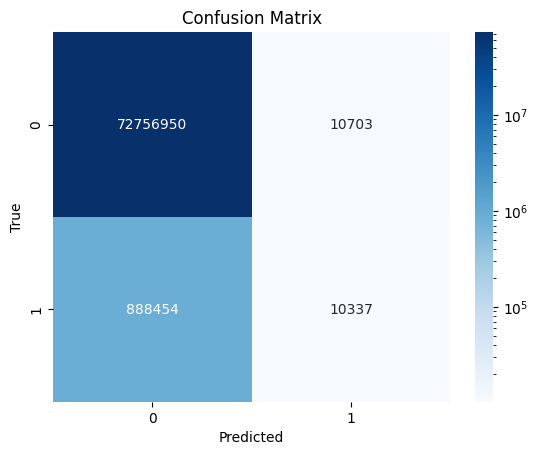

In [14]:
# import lognorm
from matplotlib.colors import LogNorm

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# log scale
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', norm=LogNorm())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
FP = torch.sum((y_true == 0) & (y_pred == 1))
FN = torch.sum((y_true == 1) & (y_pred == 0))
TP = torch.sum((y_true == 1) & (y_pred == 1))
TN = torch.sum((y_true == 0) & (y_pred == 0))

print(f'FP: {FP}, FN: {FN}, TP: {TP}, TN: {TN}')
print(f'Precision: {TP / (TP + FP)}')
print(f'Recall: {TP / (TP + FN)}')
print(f'F1 Score: {2 * TP / (2 * TP + FP + FN)}')
print(f'Accuracy: {(TP + TN) / (TP + TN + FP + FN)}')
print(f'Balanced Accuracy: {0.5 * ((TP / (TP + FN)) + (TN / (TN + FP)))}')

# sensitivity, specificity, precision, recall, f1, accuracy, balanced_accuracy, roc_auc

#  plot table with metrics



FP: 0, FN: 51779, TP: 111072, TN: 0
Precision: 1.0
Recall: 0.6820467710494995
F1 Score: 0.8109724521636963
Accuracy: 0.6820467710494995
Balanced Accuracy: nan


/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,Metric,Value
0,Precision,1.000000
1,Recall,0.682047
2,F1,0.810972
3,Accuracy,0.682047
4,Balanced Accuracy,0.682047


In [ ]:
# FP: 0, FN: 74779, TP: 35432, TN: 0
# Precision: 1.0
# Recall: 0.32149240374565125
# F1 Score: 0.48655959963798523
# Accuracy: 0.32149240374565125
# Balanced Accuracy: nan

In [56]:
#  evaluate the propagation of the missing values
#  by comparing the original data with the propagated data


def evaluate_mask_propagation(original, mask, propagated):
    # tp = torch.logical_and(original == 1, propagated == 1).sum()
    # fp = torch.logical_and(original == 0, propagated == 1).sum()
    # tn = torch.logical_and(original == 0, propagated == 0).sum()
    # fn = torch.logical_and(original == 1, propagated == 0).sum()

    # return tp, fp, tn, fn
    #  evaluate using metrics from sklearn
    y_true = original[mask]
    y_pred = propagated[mask]
    y_pred = y_pred > 0.5

    print(y_true.shape)
    print(y_pred.shape)
    # print(f'Precision score: {precision_score(y_true, y_pred)}')
    # print(f'Recall score: {recall_score(y_true, y_pred)}')
    # print(f'F1 score: {f1_score(y_true, y_pred)}')
    # print(f'Accuracy score: {accuracy_score(y_true, y_pred)}')
    # print(f'Confusion matrix: {confusion_matrix(y_true, y_pred)}')
    # print(f'Classification report: {classification_report(y_true, y_pred)}')
    return 
    

evaluate_mask_propagation(data.x, mask, cloned_data.x)

# tp, fp, tn, fn = evaluate_mask_propagation(data.x, mask, cloned_data.x)
# print(f'True positive: {tp}')
# print(f'False positive: {fp}')
# print(f'True negative: {tn}')
# print(f'False negative: {fn}')
# print(f'Precision: {tp / (tp + fp)}')
# print(f'Recall: {tp / (tp + fn)}')
# print(f'F1-score: {2 * tp / (2 * tp + fp + fn)}')



torch.Size([37209238])
torch.Size([37209238])


In [25]:
# Precision score: 0.1270711370952563
# Recall score: 0.1442619700624525
# F1 score: 0.13512197436918527
# Accuracy score: 0.9774698960510828
# Confusion matrix: [[36305423   449870]
#  [  388458    65487]]
# Classification report: 
# 
#               precision    recall  f1-score   support
#            0       0.99      0.99      0.99  36755293
#            1       0.13      0.14      0.14    453945

#     accuracy                           0.98  37209238
#    macro avg       0.56      0.57      0.56  37209238
# weighted avg       0.98      0.98      0.98  37209238

torch.Size([513176, 145])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [9]:
import umap

/home/ec2-user/miniconda3/envs/rnalab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
print(data.x[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])


UMAP( verbose=True)
Thu Oct 24 20:04:24 2024 Construct fuzzy simplicial set
Thu Oct 24 20:04:24 2024 Finding Nearest Neighbors
Thu Oct 24 20:04:24 2024 Building RP forest with 41 trees
Thu Oct 24 20:04:37 2024 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	Stopping threshold met -- exiting after 4 iterations
Thu Oct 24 20:04:58 2024 Finished Nearest Neighbor Search
Thu Oct 24 20:05:02 2024 Construct embedding


Epochs completed:   0%|            1/200 [00:01]

	completed  0  /  200 epochs


Epochs completed:  10%| █          21/200 [00:45]

	completed  20  /  200 epochs


Epochs completed:  20%| ██         41/200 [01:29]

	completed  40  /  200 epochs


Epochs completed:  30%| ███        61/200 [02:14]

	completed  60  /  200 epochs


Epochs completed:  40%| ████       81/200 [02:58]

	completed  80  /  200 epochs


Epochs completed:  50%| █████      101/200 [03:43]

	completed  100  /  200 epochs


Epochs completed:  60%| ██████     121/200 [04:27]

	completed  120  /  200 epochs


Epochs completed:  70%| ███████    141/200 [05:11]

	completed  140  /  200 epochs


Epochs completed:  80%| ████████   161/200 [05:56]

	completed  160  /  200 epochs


Epochs completed:  90%| █████████  181/200 [06:40]

	completed  180  /  200 epochs


Epochs completed: 100%| ██████████ 200/200 [07:22]


Thu Oct 24 20:14:11 2024 Finished embedding


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


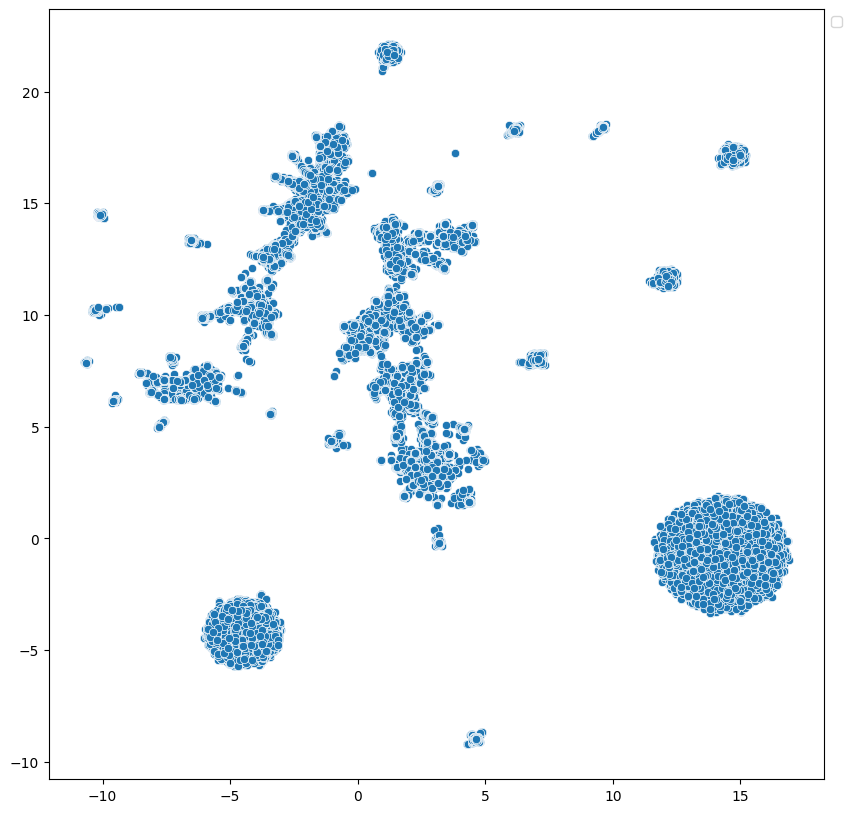

In [10]:
embd_taxon = umap.UMAP(verbose=True).fit_transform(data.x)


plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_taxon.T[0], y=embd_taxon.T[1])
# sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

In [19]:
# export fts

sotu_nodes = pd.read_csv(f'{DATA_DIR}/sotu_nodes.csv', index_col=False)


df_fts = pd.DataFrame(columns=['sotu'])
mappings = {}
for metadata_type in ['taxon', 'tissue']:
    print(f'Processing {metadata_type} metadata')
    if metadata_type == 'tissue':
        sotu_metadata =  pd.read_csv(f'{DATA_DIR}/sotu_tissues.csv', index_col=False)
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/tissue_leiden_communities.csv', index_col=False)

    elif metadata_type == 'taxon':
        sotu_metadata = pd.read_csv(f'{DATA_DIR}/sotu_has_inferred_taxon_edges.csv', index_col=False)
        sotu_metadata = sotu_metadata.rename(columns={'targetAppId': 'taxId', 'sourceNode': 'nodeId', 'sourceAppId': 'sotu'})
        metadata_fts = pd.read_csv(f'{FEATURES_DIR}/taxon_leiden_communities.csv', index_col=False)

    for hierarchy_level in range(5):
        print(f'Processing hierarchy level {hierarchy_level}')
        metadata_fts = get_label_from_communities(metadata_fts, level=hierarchy_level)
        print(f'Total number of classes: {metadata_fts["targetLevel"].nunique()}')
        sotu_fts_df = get_multi_class_encoding(sotu_nodes, sotu_metadata, metadata_fts, mappings, metadata_type)

        sotu_fts_df = sotu_fts_df.rename(columns={'targetLevel': f'{metadata_type}_{hierarchy_level}'})
        df_fts = pd.merge(df_fts, sotu_fts_df, on='sotu', how='outer')

df_fts.to_csv(f'{FEATURES_DIR}/sotu_fts.csv', index=False)

Processing taxon metadata
Processing hierarchy level 0
Total number of classes: 195882
Processing hierarchy level 1
Total number of classes: 51433
Processing hierarchy level 2
Total number of classes: 10131
Processing hierarchy level 3
Total number of classes: 2695
Processing hierarchy level 4
Total number of classes: 1407
Processing tissue metadata
Processing hierarchy level 0
Total number of classes: 1622
Processing hierarchy level 1
Total number of classes: 521
Processing hierarchy level 2
Total number of classes: 195
Processing hierarchy level 3
Total number of classes: 118
Processing hierarchy level 4
Total number of classes: 108


In [30]:
# concat all features (only for non-isolated nodes)

df_fts = pd.read_csv(f'{FEATURES_DIR}/sotu_fts.csv', index_col=False)
print(df_fts.shape)
encoders = {}
for col in df_fts.columns:
    if 'taxon' in col or 'tissue' in col:
        encoders[col] = ListEncoder(is_tensor=True)


isolated_sotus = pd.read_csv(f'{DATA_DIR}/isolated_sotus.csv', index_col=False)
isolated_sotus = isolated_sotus['sotu'].values
df_fts = df_fts[~df_fts['sotu'].isin(isolated_sotus)]

print(df_fts.shape)



(513176, 11)
(146110, 11)


In [37]:
# randomly sample nodes
df_fts_tmp = df_fts.sample(50000)

sotu_x, sotu_mapping = load_node_tensor(
    df=df_fts_tmp,
    index_col='sotu',
    encoders=encoders,
)


In [40]:
print(sotu_x.shape)

torch.Size([10000, 10031])


UMAP( verbose=True)
Mon Oct 28 02:59:25 2024 Construct fuzzy simplicial set
Mon Oct 28 02:59:25 2024 Finding Nearest Neighbors
Mon Oct 28 02:59:25 2024 Building RP forest with 10 trees
Mon Oct 28 02:59:29 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Mon Oct 28 02:59:39 2024 Finished Nearest Neighbor Search
Mon Oct 28 02:59:39 2024 Construct embedding


Epochs completed:   1%|            5/500 [00:01]

	completed  0  /  500 epochs


Epochs completed:  11%| █          56/500 [00:03]

	completed  50  /  500 epochs


Epochs completed:  21%| ██         104/500 [00:04]

	completed  100  /  500 epochs


Epochs completed:  31%| ███        155/500 [00:06]

	completed  150  /  500 epochs


Epochs completed:  41%| ████       206/500 [00:08]

	completed  200  /  500 epochs


Epochs completed:  51%| █████      254/500 [00:10]

	completed  250  /  500 epochs


Epochs completed:  61%| ██████     305/500 [00:11]

	completed  300  /  500 epochs


Epochs completed:  71%| ███████    356/500 [00:13]

	completed  350  /  500 epochs


Epochs completed:  81%| ████████   404/500 [00:15]

	completed  400  /  500 epochs


Epochs completed:  91%| █████████  455/500 [00:17]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:18]


Mon Oct 28 02:59:58 2024 Finished embedding


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


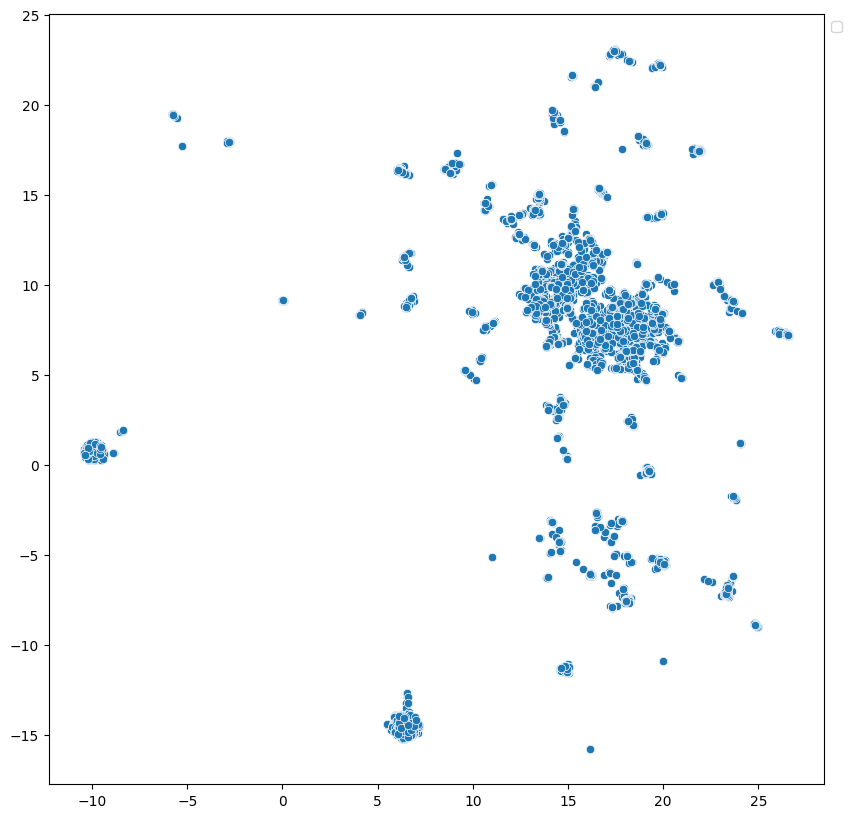

In [38]:
import umap

embd = umap.UMAP(verbose=True).fit_transform(sotu_x)

plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1])
# sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')